# Data Exploration and Feature Engineering

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


pd.set_option('display.max_columns', None)  # To display all columns
pd.set_option('display.width', None)        # To avoid line wrapping
pd.set_option('display.max_rows', 100)

## Team Factor Feature

This proposed feature will theoretically help to account for how a players home field affects the number of homeruns a player may hit. Formula to calculate it will be:

$$ team factor = \frac{team score}{max(team score)} $$

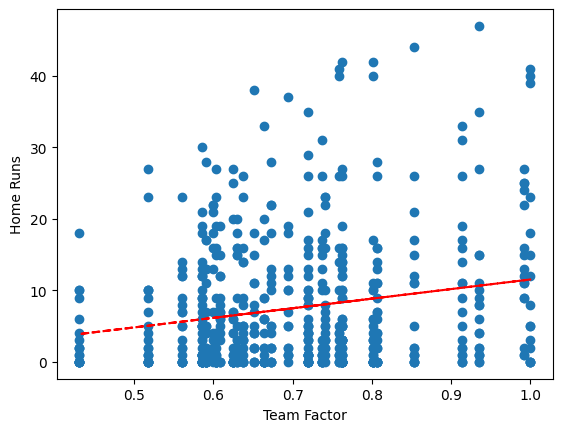

In [2]:
# Loading a 2015 team stats data set into a dataframe 
team_stats = pd.read_csv("../../data/raw/team_stats_2015.csv")

# adding a column for team factor feature
team_stats.insert(0, "tmFactor", 0)

# populating the team factor column for each team   
team_stats["tmFactor"] = team_stats["HR"]/max(team_stats["HR"])

# creating a dictionary of Team: team Factor
team_factor = team_stats.set_index("Team")["tmFactor"].to_dict()

# loading a season dataset and cleaning out some columns that are duplicates or
# appear to be blank on many rows based on a quick scan in excel
players =  pd.read_csv("../../data/raw/MLB_player_stats_2015.csv")
players = players[players['PA'] >= 20]
players = players.drop(columns=['Name.1', 'Team.1','UBR', 'wGDP', 'XBR'], axis=1)
#####players = players.drop(columns=['Name.1', 'Team.1'], axis=1)
# adding and populating team factor column on player stats data set
players.insert(0,  "tmFactor", 0)
players["tmFactor"] = players["Team"].map(team_factor)

# drop nan rows for team factor.
# These are caused by players that played for multiple teams in a season as their Team is listed as "- - -"

players = players.dropna(subset = ['tmFactor'])

# assigning columns to variables to for scatter plot and trendline
x = players["tmFactor"]
y = players["HR"]
z = np.polyfit(x, y, 1) # fits a linear polynomial
p = np.poly1d(z)    # creates a polynomial function from coefficients from z


plt.scatter(x,y)
plt.plot(x, p(x), "r--")
plt.xlabel("Team Factor")
plt.ylabel("Home Runs")
plt.show()

## Centering the team factor

A mean centered feature is "centered around the mean" by replacing the value with the value - mean value.  In ths case:

centered team factor = team factor - mean team factor 

or

$ x_i = x_i - \bar{x}$

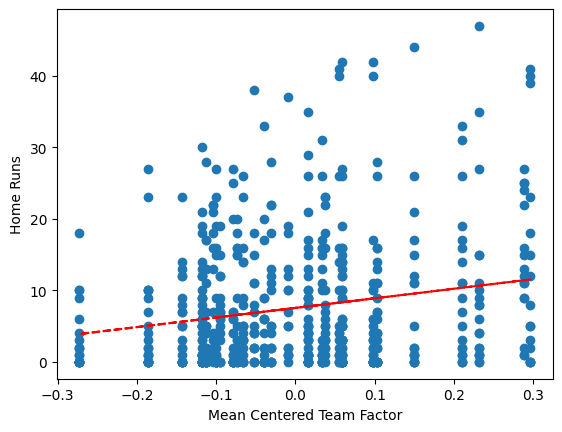

In [3]:
x_tm_factor_centered = players['tmFactor'] - players['tmFactor'].mean()

y = players["HR"]
z = np.polyfit(x_tm_factor_centered, y, 1) # fits a linear polynomial
p = np.poly1d(z)    # creates a polynomial function from coefficients from z


plt.scatter(x_tm_factor_centered,y)
plt.plot(x_tm_factor_centered, p(x_tm_factor_centered), "r--")
plt.xlabel("Mean Centered Team Factor")
plt.ylabel("Home Runs")
plt.show()

Text(0, 0.5, 'Home Runs')

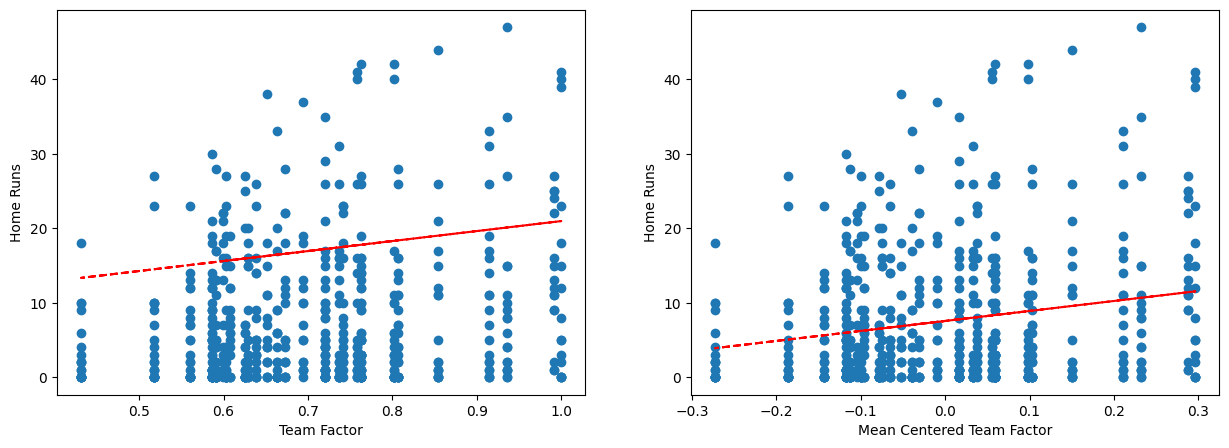

In [4]:
#from matplotlib.pyplot import subplots

fig, axes = plt.subplots(nrows=1,
                     ncols=2,
                     figsize=(15,5))

axes[1].scatter(x_tm_factor_centered,y)
axes[1].plot(x_tm_factor_centered, p(x_tm_factor_centered), "r--")
axes[1].set_xlabel("Mean Centered Team Factor")
axes[1].set_ylabel("Home Runs")

axes[0].scatter(x,y)
axes[0].plot(x, p(x), "r--")
axes[0].set_xlabel("Team Factor")
axes[0].set_ylabel("Home Runs")



mean centering does not change the shape of the data, but it does affect the location of the intercept of the plot line. This can help with colinearity and will be used for a second iteration of our linear regression model.

## Handling players who played for more than one team

$ Weighted team factor = \frac{\sum_i^n team_i Factor \times team_i PAs}{\sum_i^n team_i PA} $

This value will be calculated using the player stats with team splits and then inserted to the main data set.

## Player ages
Players ages will be scaled using the following formula:

$ \text{scaled player age} = \frac{\text{player age}}{50} $

## Season Factor
A scaled season factor will be used to account for changes to the game from season to season, such as the shortened 2020 season, balls started to be kept in humidors, or the introduction of the pitch clock.

This stat will be calculated much like the team factor stat

$ \text{Season factor} = \frac{season HRs}{max(season HRs)} $

The code snippet below if from the data processing script that shows how the season factor is generated and applied to the data set.


    # while looping through the datasets for each season
        # Create a new row in a DataFrame format to store the total number of homeruns for the sesaon
        new_row = pd.DataFrame({'season': [season], 'HR_total': [team_stats_df['HR'].sum()]})

        # Concatenate the new row with the existing DataFrame to store season total homeruns
        season_factor_df = pd.concat([season_factor_df, new_row], ignore_index=True)

        # Combine data into the main dataset
        combined_data_df = pd.concat([combined_data_df, player_stats_df], ignore_index=True)
    # end of loop

    # generate dictionary of season factors
    season_factor_df.insert(0, "season_factor", 0)
    season_factor_df['season_factor'] = season_factor_df['HR_total']/max(season_factor_df['HR_total'])
    season_factor_dict = season_factor_df.set_index('season')['season_factor'].to_dict()

    # Add season factor to the dataframe
    combined_data_df.insert(0, "season_factor", 0)
    combined_data_df["season_factor"] = combined_data_df["Season"].map(season_factor_dict)



## Selecting features for initial linear regression model
I will start by examining correlation by generating a correlation matrix

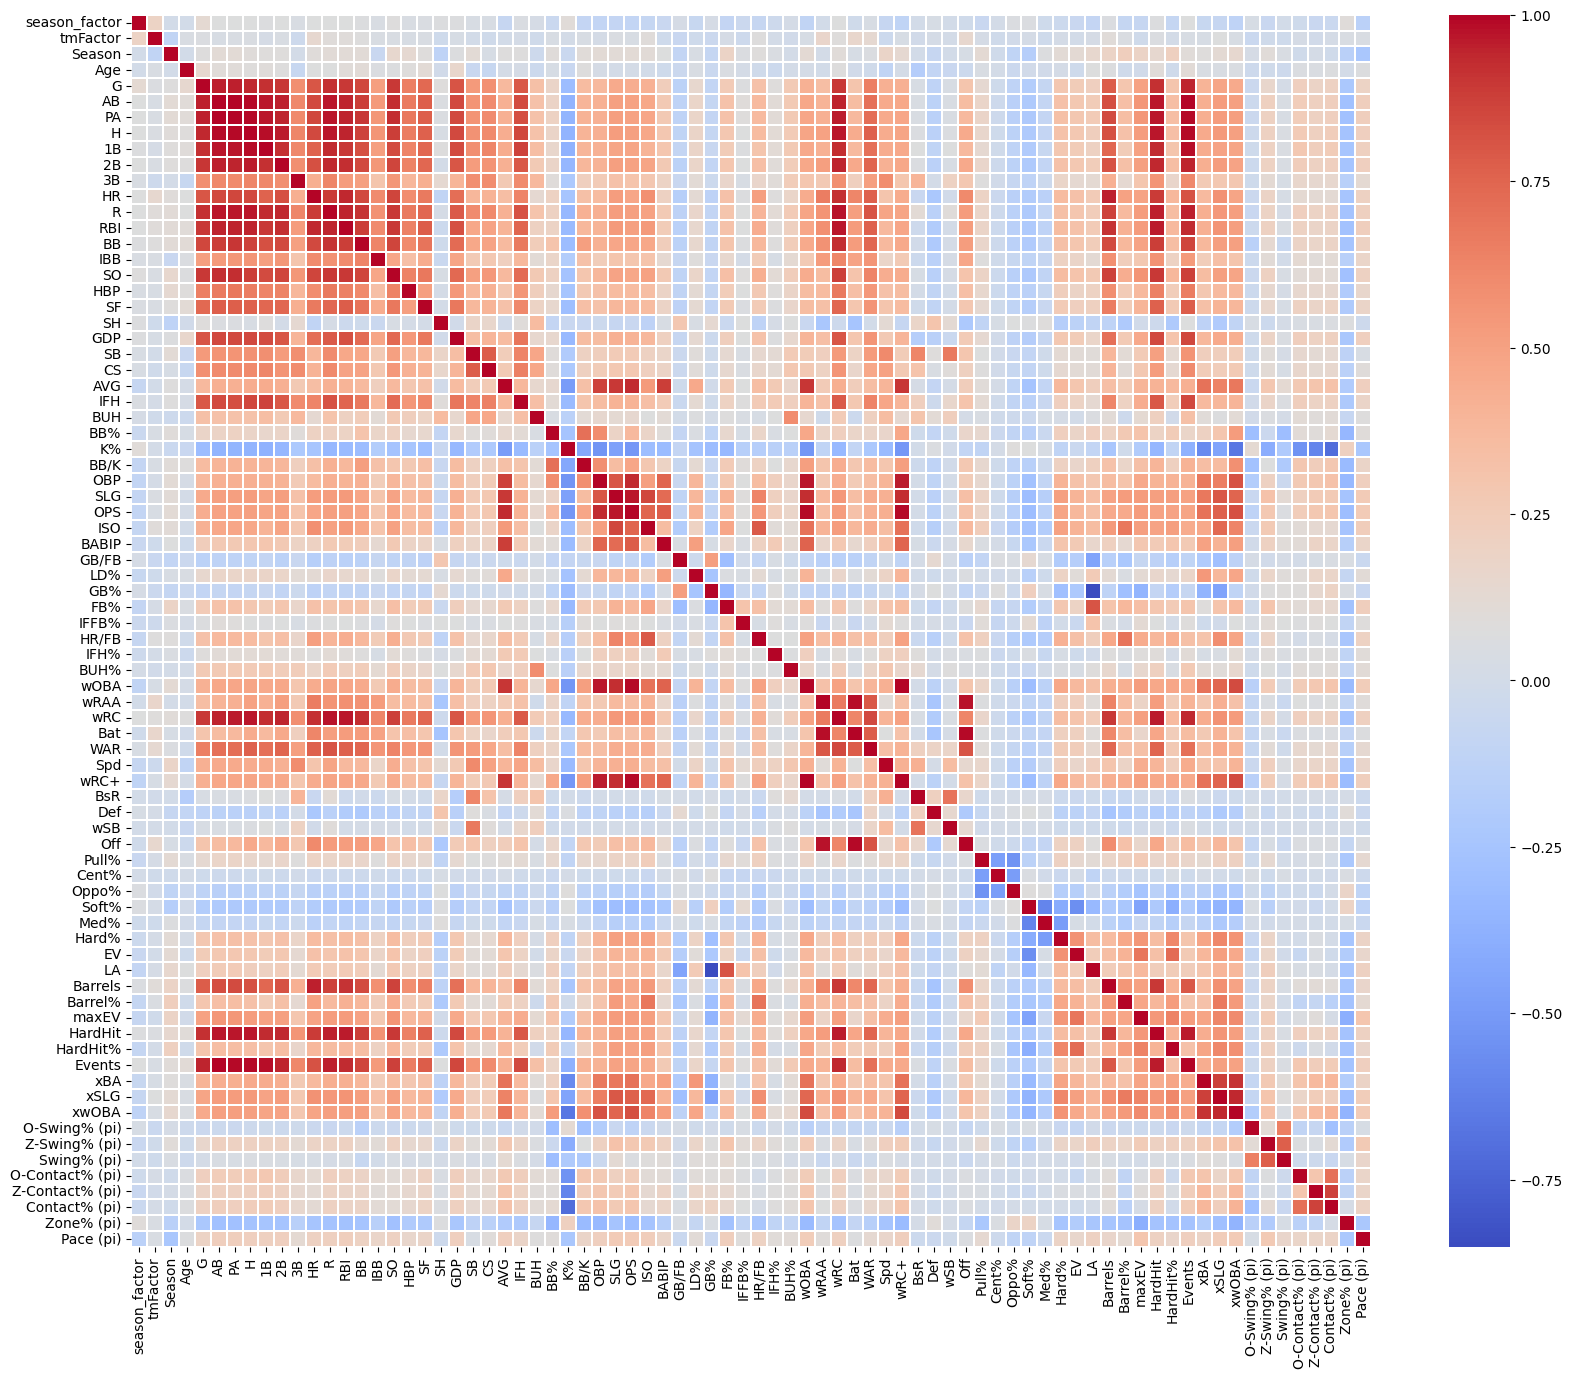

In [5]:
import seaborn as sns
#players_df = pd.read_csv('../../data/processed/nicks_dataset.csv')
players_df = pd.read_csv('../../data/processed/combined_player_stats.csv')
players_df = players_df.drop(columns=['Name', 'Team', 'Name.1', 'Team.1','NameASCII','PlayerId','MLBAMID','UBR', 'wGDP', 'XBR'], axis=1)

correlation_matrix = players_df.corr()
plt.figure(figsize=(20,16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.1)
plt.show()



In [6]:
target = "HR"
target_corr = correlation_matrix[target].sort_values(ascending=False)

print("Feature Correlation with Target:")
print(target_corr.to_string())

Feature Correlation with Target:
HR                 1.000000
Barrels            0.950002
RBI                0.940067
wRC                0.915917
R                  0.890957
HardHit            0.888977
SO                 0.858090
PA                 0.855113
AB                 0.847008
H                  0.844005
BB                 0.843139
2B                 0.819400
Events             0.816571
G                  0.797992
WAR                0.766209
1B                 0.754913
GDP                0.717416
SF                 0.669875
wRAA               0.659078
IFH                0.628069
Bat                0.621447
Off                0.603960
IBB                0.599864
HBP                0.593339
ISO                0.575268
xSLG               0.568554
SLG                0.517860
HR/FB              0.508497
Barrel%            0.493972
maxEV              0.490829
xwOBA              0.483705
OPS                0.476265
wRC+               0.447066
wOBA               0.444578
3B             

In [7]:
players_df.head

<bound method NDFrame.head of       season_factor  tmFactor  Season   Age    G   AB   PA    H  1B  2B  3B  \
0          0.724469  0.603448    2015  0.76   26   42   52    5   4   0   0   
1          0.724469  0.762931    2015  0.46    3    2    2    0   0   0   0   
2          0.724469  0.806034    2015  0.68   63  181  217   43  27   9   0   
3          0.724469  0.431034    2015  0.76  113  407  436  122  88  24   1   
4          0.724469  0.560345    2015  0.48   39  137  161   33  13  11   4   
...             ...       ...     ...   ...  ...  ...  ...  ...  ..  ..  ..   
8495       0.804752  0.683544    2024  0.58  118  297  325   64  41  14   5   
8496       0.804752  0.696203    2024  0.46  155  542  602  135  77  34   1   
8497       0.804752  0.561181    2024  0.60   15   33   39    8   6   1   1   
8498       0.804752  0.827004    2024  0.48  138  497  547  105  66  20   2   
8499       0.804752  0.888905    2024  0.58   42   70   88    9   6   3   0   

      HR   R  RBI  BB

## Variance inflation factor

In [8]:
# Compute VIF for each feature
features = players_df.drop(columns=[target]).dropna(ignore_index=True)  # All columns except target
features.head

<bound method NDFrame.head of       season_factor  tmFactor  Season   Age    G   AB   PA    H  1B  2B  3B  \
0          0.724469  0.603448    2015  0.76   26   42   52    5   4   0   0   
1          0.724469  0.762931    2015  0.46    3    2    2    0   0   0   0   
2          0.724469  0.806034    2015  0.68   63  181  217   43  27   9   0   
3          0.724469  0.431034    2015  0.76  113  407  436  122  88  24   1   
4          0.724469  0.560345    2015  0.48   39  137  161   33  13  11   4   
...             ...       ...     ...   ...  ...  ...  ...  ...  ..  ..  ..   
7462       0.804752  0.683544    2024  0.58  118  297  325   64  41  14   5   
7463       0.804752  0.696203    2024  0.46  155  542  602  135  77  34   1   
7464       0.804752  0.561181    2024  0.60   15   33   39    8   6   1   1   
7465       0.804752  0.827004    2024  0.48  138  497  547  105  66  20   2   
7466       0.804752  0.888905    2024  0.58   42   70   88    9   6   3   0   

       R  RBI  BB  IB

In [9]:

vif_data = pd.DataFrame()
vif_data["Feature"] = features.columns
vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

print("Variance Inflation Factor (VIF):")
print(vif_data)

C:\Users\nick_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Variance Inflation Factor (VIF):
            Feature           VIF
0     season_factor  1.315488e+00
1          tmFactor  1.186864e+00
2            Season  1.566226e+06
3               Age  1.172106e+00
4                 G  2.107677e+01
5                AB  1.982576e+05
6                PA           inf
7                 H  3.086596e+04
8                1B  4.256900e+03
9                2B  2.262900e+02
10               3B  4.486371e+00
11                R  5.094542e+01
12              RBI  3.561279e+01
13               BB           inf
14              IBB  4.105129e+00
15               SO           inf
16              HBP           inf
17               SF  2.494397e+01
18               SH  1.705611e+01
19              GDP  4.649043e+00
20               SB  1.640045e+02
21               CS  6.656914e+01
22              AVG           inf
23              IFH  5.270489e+00
24              BUH  2.363978e+00
25              BB%  1.700148e+01
26               K%  5.249606e+00
27             

### Interpreting VIF data can be done with the following criteria

| **VIF Value**       | **Interpretation**                                        |
|---------------------|-----------------------------------------------------------|
| **1**               | No correlation between the feature and other features.    |
| **1 < VIF < 5**     | Moderate correlation, but not problematic.                |
| **5 < VIF < 10**    | High correlation. This is a warning that multicollinearity might be an issue. |
| **VIF > 10**        | Very high correlation, indicating significant multicollinearity. This could cause issues with model stability and interpretation. |

Using these criteria, I will filter down feature lists for VIF values <=1, <5 and <10, and train a model with each set of features for comparison.

In [10]:
# Filter out features with VIF greater than 10
vif_threshold = 10

filtered_features = vif_data[vif_data["VIF"] < vif_threshold]["Feature"].tolist()

# Remove features with high VIF from X
players_filtered = players_df[filtered_features]

print(players_filtered)

      season_factor  tmFactor   Age  3B  IBB  GDP  IFH  BUH        K%  \
0          0.724469  0.603448  0.76   0    0    1    0    0  0.384615   
1          0.724469  0.762931  0.46   0    0    1    0    0  0.000000   
2          0.724469  0.806034  0.68   0    1    4    1    0  0.175115   
3          0.724469  0.431034  0.76   1    2   19    7    0  0.084862   
4          0.724469  0.560345  0.48   4    0    3    3    0  0.254658   
...             ...       ...   ...  ..  ...  ...  ...  ...       ...   
8495       0.804752  0.683544  0.58   5    0    3    3    0  0.212308   
8496       0.804752  0.696203  0.46   1    1   14    9    1  0.232558   
8497       0.804752  0.561181  0.60   1    0    1    1    0  0.256410   
8498       0.804752  0.827004  0.48   2    0    7    8    1  0.343693   
8499       0.804752  0.888905  0.58   0    0    0    1    1  0.272727   

          BB/K     BABIP     GB/FB     IFFB%     HR/FB      IFH%      BUH%  \
0     0.000000  0.181818  5.000000  0.000000 

This is interesting, when I originally explored the data, I worked with one season as the combined dataset had not been built yet. I also did not have the season factor incuded yet. This updated dataset produced a filtered list of features with at east 10 more features than when when I previously explored the data and practiced training a model. I can also see some of the columns have NaN values so I will check to see how prevelent they are.

In [11]:
# Count how many NaN values there are in each column
nan_counts = players_filtered.isna().sum()

# Print the result
print(nan_counts)

season_factor        0
tmFactor           170
Age                  0
3B                   0
IBB                  0
GDP                  0
IFH                  0
BUH                  0
K%                   0
BB/K                 0
BABIP                0
GB/FB                0
IFFB%                0
HR/FB                0
IFH%                 0
BUH%                 0
Spd                  0
EV                 576
LA                 576
Barrel%            449
maxEV              576
HardHit%           449
O-Contact% (pi)    656
Z-Contact% (pi)    178
Zone% (pi)           5
Pace (pi)           49
dtype: int64


In [12]:
players_filtered.dropna(ignore_index = True)


,season_factor,tmFactor,Age,3B,IBB,GDP,IFH,BUH,K%,BB/K,BABIP,GB/FB,IFFB%,HR/FB,IFH%,BUH%,Spd,EV,LA,Barrel%,maxEV,HardHit%,O-Contact% (pi),Z-Contact% (pi),Zone% (pi),Pace (pi)
0,0.724469,0.603448,0.76,0,0,1,0,0,0.384615,0.000000,0.181818,5.000000,0.000000,0.333333,0.000000,0.000000,0.142857,84.500738,-9.018391,0.031250,104.322,0.218750,0.312500,0.816667,0.703911,22.119048
1,0.724469,0.762931,0.46,0,0,1,0,0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.142857,76.032501,16.334999,0.000000,82.962,0.000000,0.500000,1.000000,0.200000,20.250000
2,0.724469,0.806034,0.68,0,1,4,1,0,0.175115,0.842105,0.264706,1.240000,0.020000,0.140000,0.016129,0.000000,1.080357,87.681620,9.801383,0.054795,108.544,0.328767,0.615385,0.888087,0.566955,22.139738
3,0.724469,0.431034,0.76,1,2,19,7,0,0.084862,0.513514,0.310440,1.626168,0.121495,0.084112,0.040230,0.000000,1.736382,85.400034,10.583399,0.029491,109.962,0.254692,0.769517,0.923379,0.481092,22.454822
4,0.724469,0.560345,0.48,4,0,3,3,0,0.254658,0.390244,0.301075,1.054054,0.108108,0.135135,0.076923,0.000000,8.036122,90.904075,11.568464,0.020202,110.026,0.434343,0.500000,0.861538,0.507837,20.627706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7463,0.804752,0.683544,0.58,5,0,3,3,0,0.212308,0.347826,0.265487,0.773196,0.041237,0.041237,0.040000,0.000000,8.182890,87.978473,18.683960,0.043478,108.147,0.326087,0.605714,0.884615,0.521217,17.656489
7464,0.804752,0.696203,0.46,1,1,14,9,1,0.232558,0.278571,0.294737,1.142857,0.090909,0.149351,0.051136,0.125000,5.427539,88.491275,12.305902,0.083538,111.306,0.385749,0.530556,0.839096,0.497160,18.721625
7465,0.804752,0.561181,0.60,1,0,1,1,0,0.256410,0.500000,0.347826,1.571429,0.000000,0.000000,0.090909,0.000000,6.500663,86.866048,14.331496,0.041667,105.293,0.291667,0.500000,0.866667,0.589404,17.292035
7466,0.804752,0.827004,0.48,2,0,7,8,1,0.343693,0.202128,0.296296,1.118644,0.110169,0.144068,0.060606,0.166667,6.394459,89.197045,14.237215,0.088328,109.136,0.372240,0.357664,0.756410,0.539659,18.735020


In [13]:
# Extract the column names from the dataframe
column_names = players_filtered.columns.tolist()
column_names.extend(['HR', 'Season'])


with open('../../data/lr_model1_feature_list.txt', 'w') as f:
    for column in column_names:
        f.write(column + '\n')


In [14]:
vif_threshold = 5

filtered_features = vif_data[vif_data["VIF"] < vif_threshold]["Feature"].tolist()

# Remove features with high VIF from X
players_filtered = players_df[filtered_features]

print(players_filtered)

      season_factor  tmFactor   Age  3B  IBB  GDP  BUH     GB/FB     IFFB%  \
0          0.724469  0.603448  0.76   0    0    1    0  5.000000  0.000000   
1          0.724469  0.762931  0.46   0    0    1    0  1.000000  0.000000   
2          0.724469  0.806034  0.68   0    1    4    0  1.240000  0.020000   
3          0.724469  0.431034  0.76   1    2   19    0  1.626168  0.121495   
4          0.724469  0.560345  0.48   4    0    3    0  1.054054  0.108108   
...             ...       ...   ...  ..  ...  ...  ...       ...       ...   
8495       0.804752  0.683544  0.58   5    0    3    0  0.773196  0.041237   
8496       0.804752  0.696203  0.46   1    1   14    1  1.142857  0.090909   
8497       0.804752  0.561181  0.60   1    0    1    0  1.571429  0.000000   
8498       0.804752  0.827004  0.48   2    0    7    1  1.118644  0.110169   
8499       0.804752  0.888905  0.58   0    0    0    1  0.583333  0.083333   

         HR/FB      IFH%      BUH%       Spd         EV    maxE

In [15]:
players_filtered.dropna(ignore_index = True, inplace=True)
print(players_filtered)

      season_factor  tmFactor   Age  3B  IBB  GDP  BUH     GB/FB     IFFB%  \
0          0.724469  0.603448  0.76   0    0    1    0  5.000000  0.000000   
1          0.724469  0.762931  0.46   0    0    1    0  1.000000  0.000000   
2          0.724469  0.806034  0.68   0    1    4    0  1.240000  0.020000   
3          0.724469  0.431034  0.76   1    2   19    0  1.626168  0.121495   
4          0.724469  0.560345  0.48   4    0    3    0  1.054054  0.108108   
...             ...       ...   ...  ..  ...  ...  ...       ...       ...   
7779       0.804752  0.683544  0.58   5    0    3    0  0.773196  0.041237   
7780       0.804752  0.696203  0.46   1    1   14    1  1.142857  0.090909   
7781       0.804752  0.561181  0.60   1    0    1    0  1.571429  0.000000   
7782       0.804752  0.827004  0.48   2    0    7    1  1.118644  0.110169   
7783       0.804752  0.888905  0.58   0    0    0    1  0.583333  0.083333   

         HR/FB      IFH%      BUH%       Spd         EV    maxE

C:\Users\nick_\AppData\Local\Temp\ipykernel_20192\1879401192.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_filtered.dropna(ignore_index = True, inplace=True)


This new list filtered to VIF values < 5 is a little bigger featurewise than what I ended up with while practicing as well.

In [16]:
# Count how many NaN values there are in each column
nan_counts = players_filtered.isna().sum()

# Print the result
print(nan_counts)

season_factor    0
tmFactor         0
Age              0
3B               0
IBB              0
GDP              0
BUH              0
GB/FB            0
IFFB%            0
HR/FB            0
IFH%             0
BUH%             0
Spd              0
EV               0
maxEV            0
HardHit%         0
Zone% (pi)       0
Pace (pi)        0
dtype: int64


In [17]:
# Extract the column names from the dataframe
column_names = players_filtered.columns.tolist()
column_names.extend(['HR', 'Season'])


with open('../../data/lr_model2_feature_list.txt', 'w') as f:
    for column in column_names:
        f.write(column + '\n')

In [18]:
vif_threshold = 1

filtered_features = vif_data[vif_data["VIF"] <= vif_threshold]["Feature"].tolist()

# Remove features with high VIF from X
players_filtered = players_df[filtered_features]

print(players_filtered)

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[8500 rows x 0 columns]


No columns have a vif less than one. So there will be no feature lists with this parameter.

## Lastly I will manually pick a feature list based on shapes of scatter plots and intuition based on familiarity with baseball to compare to the other models.

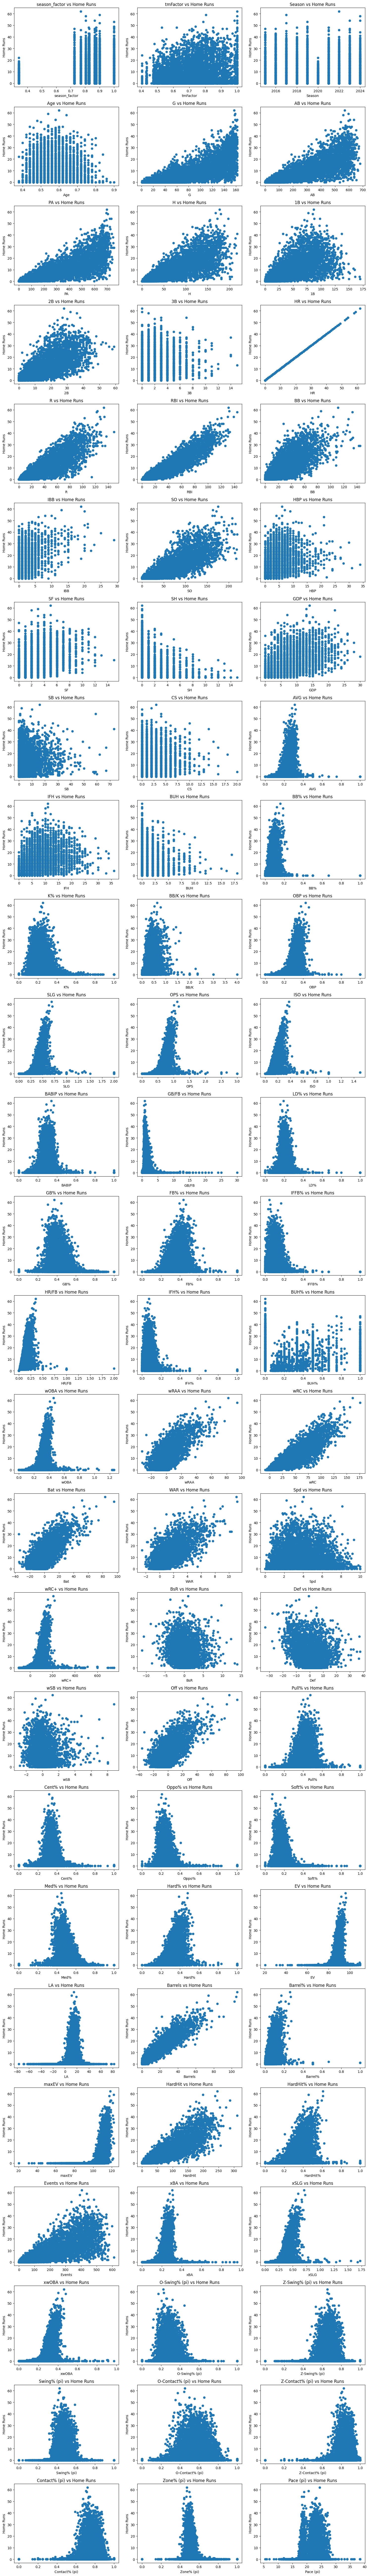

In [19]:
features = players_df.columns

n_features = len(features)

# Adjust number of columns per row here
cols = 3
rows = int(np.ceil(n_features / cols))

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5*cols, 4*rows))
axes = axes.flatten()  # flatten in case it's 2D
y = players_df[target]
for i, feature in enumerate(features):
    x = players_df[feature]
    axes[i].scatter(x, y)
    

    axes[i].set_title(f"{feature} vs Home Runs")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Home Runs")

# Turn off any extra unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Based on the shapes of the scatter plots above, selecting the following  
'season_factor', 'tmFactor',  'Age', 'G', 'PA', 'H', 'R', 'RBI', 'BB', 'SO', 'Barrel%', 'HardHit%'

resetting the features dataframe and rerunning the VIF calculations with new manually selected feature list.

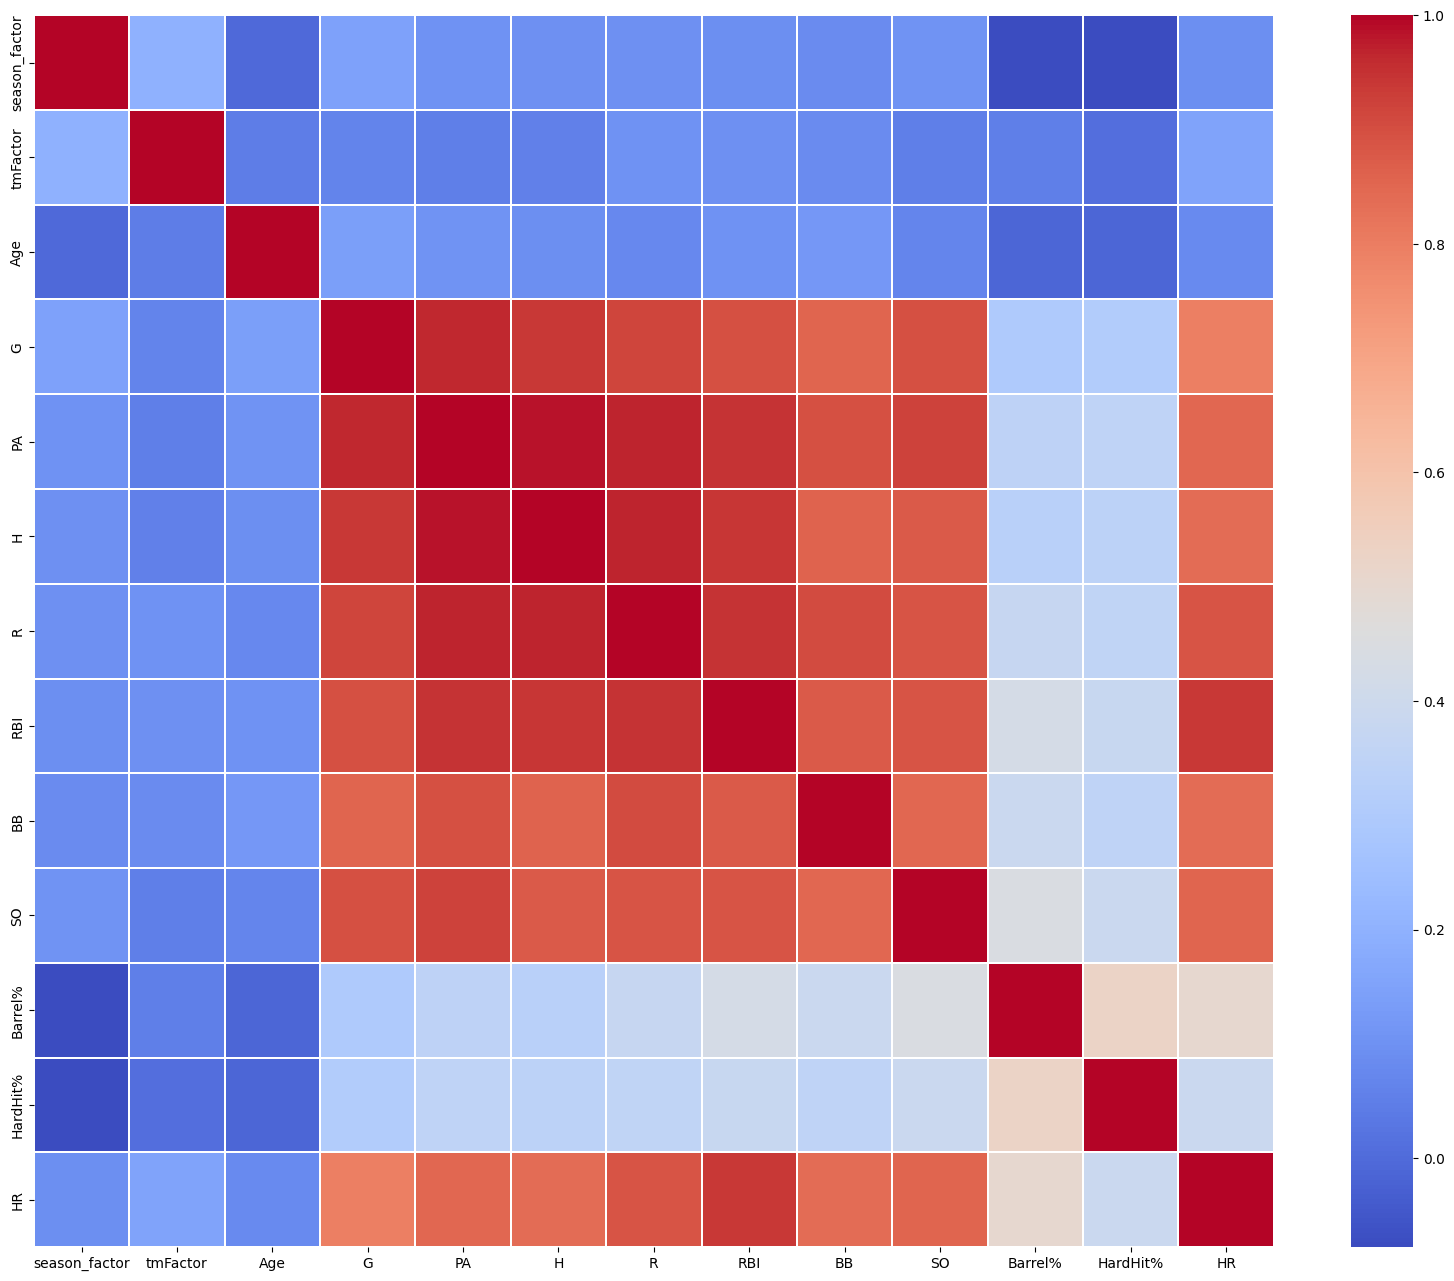

In [20]:
selected_columns = ['season_factor', 'tmFactor',  'Age', 'G', 'PA', 'H', 'R', 'RBI', 'BB', 'SO', 'Barrel%', 'HardHit%', 'HR']
temp_players_df =  players_df[selected_columns].dropna(ignore_index=True)
correlation_matrix = temp_players_df.corr()
plt.figure(figsize=(20,16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.1)
plt.show()

In [21]:
target = "HR"
target_corr = correlation_matrix[target].sort_values(ascending=False)

print("Feature Correlation with Target:")
print(target_corr.to_string())

Feature Correlation with Target:
HR               1.000000
RBI              0.938058
R                0.886952
SO               0.853256
PA               0.849976
H                0.837984
BB               0.837103
G                0.796386
Barrel%          0.502960
HardHit%         0.389474
tmFactor         0.152481
season_factor    0.092800
Age              0.078403


Now I am going to manually select features to remove until the remaining calculated VIFs are all in a range I want to try
starting by removing age as it does not seem to have any correlation to HRs hit. I think if you were able to model the data so it tracked each player specifically for multiple seasons, age might be more important.

In [22]:

selected_columns = ['season_factor', 'tmFactor', 'G', 'PA', 'H', 'R', 'RBI', 'BB', 'SO', 'Barrel%', 'HardHit%']
features = players_df[selected_columns].dropna(ignore_index=True)

vif_data = pd.DataFrame()
vif_data["Feature"] = features.columns
vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

print("Variance Inflation Factor (VIF):")
print(vif_data)

Variance Inflation Factor (VIF):
          Feature         VIF
0   season_factor   21.464167
1        tmFactor   20.871046
2               G   41.900047
3              PA  238.552979
4               H  137.827594
5               R   47.694424
6             RBI   22.139597
7              BB   13.548935
8              SO   21.665536
9         Barrel%    3.139142
10       HardHit%    5.770173


next going to try removing PA  du to the high colinearity 

In [23]:

selected_columns = ['season_factor', 'tmFactor', 'G', 'H', 'R', 'RBI', 'BB', 'SO', 'Barrel%', 'HardHit%']
features = players_df[selected_columns].dropna(ignore_index=True)

vif_data = pd.DataFrame()
vif_data["Feature"] = features.columns
vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

print("Variance Inflation Factor (VIF):")
print(vif_data)

Variance Inflation Factor (VIF):
         Feature        VIF
0  season_factor  21.443798
1       tmFactor  20.858772
2              G  32.203586
3              H  52.974553
4              R  47.523235
5            RBI  22.136968
6             BB  11.013715
7             SO  15.476471
8        Barrel%   3.117753
9       HardHit%   5.765888


Next trying to remove team factor

In [24]:

selected_columns = ['season_factor', 'G', 'H', 'R', 'RBI', 'BB', 'SO', 'Barrel%', 'HardHit%']
features = players_df[selected_columns].dropna(ignore_index=True)

vif_data = pd.DataFrame()
vif_data["Feature"] = features.columns
vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

print("Variance Inflation Factor (VIF):")
print(vif_data)

Variance Inflation Factor (VIF):
         Feature        VIF
0  season_factor   5.725218
1              G  31.060645
2              H  51.474321
3              R  46.825087
4            RBI  22.019191
5             BB  10.989323
6             SO  15.065417
7        Barrel%   2.956544
8       HardHit%   5.332124


This did not change much, so I will add it back in and try removing hits instead

In [25]:

selected_columns = ['season_factor', 'tmFactor', 'G', 'R', 'RBI', 'BB', 'SO', 'Barrel%', 'HardHit%']
features = players_df[selected_columns].dropna(ignore_index=True)

vif_data = pd.DataFrame()
vif_data["Feature"] = features.columns
vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

print("Variance Inflation Factor (VIF):")
print(vif_data)

Variance Inflation Factor (VIF):
         Feature        VIF
0  season_factor  21.443777
1       tmFactor  20.531025
2              G  24.017653
3              R  27.110660
4            RBI  19.151925
5             BB  10.163375
6             SO  15.183544
7        Barrel%   3.040916
8       HardHit%   5.689859


Removing hits seemed to drop runs VIF considerably. going to drop runs next

In [26]:

selected_columns = ['season_factor', 'tmFactor', 'G', 'RBI', 'BB', 'SO', 'Barrel%', 'HardHit%']
features = players_df[selected_columns].dropna(ignore_index=True)

vif_data = pd.DataFrame()
vif_data["Feature"] = features.columns
vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

print("Variance Inflation Factor (VIF):")
print(vif_data)

Variance Inflation Factor (VIF):
         Feature        VIF
0  season_factor  21.194453
1       tmFactor  20.489280
2              G  21.409588
3            RBI  13.238839
4             BB   8.549044
5             SO  15.138562
6        Barrel%   3.030780
7       HardHit%   5.689733


RBI is directly affected by homeruns, as each homeruns gives a player at least one rbi. I am going to try and combine RBIs and Games and see how that affects the VIF values.

In [27]:
features['RBI'] = features['RBI']/features['G']
features.rename(columns={'RBI': 'RBI/G'}, inplace=True)
vif_data["Feature"] = features.columns
vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

print("Variance Inflation Factor (VIF):")
print(vif_data)


Variance Inflation Factor (VIF):
         Feature        VIF
0  season_factor  20.872755
1       tmFactor  20.977235
2              G  17.867300
3          RBI/G   5.875225
4             BB   7.534300
5             SO  14.586034
6        Barrel%   3.256552
7       HardHit%   5.942025


combining those did a lot to drop the VIF in comparison to RBI. I'm going to try and combine tmFactor and Season_factor by multiplying them.

In [28]:
features['tmFactor'] = features['tmFactor']/features['season_factor']
features.rename(columns={'tmFactor': 'tmFactorXseason_factor'}, inplace=True)

vif_data["Feature"] = features.columns
vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

print("Variance Inflation Factor (VIF):")
print(vif_data)

Variance Inflation Factor (VIF):
                  Feature        VIF
0           season_factor   6.880181
1  tmFactorXseason_factor   5.428480
2                       G  17.882291
3                   RBI/G   6.047049
4                      BB   7.551205
5                      SO  14.642628
6                 Barrel%   3.253290
7                HardHit%   6.153749


I think this is as close as I want to get. without something to indicate the amount of opportunities a player gets to hit a home rune it feels like this would not work. going to rebuild list with new combined features and run one last correlation matrix.

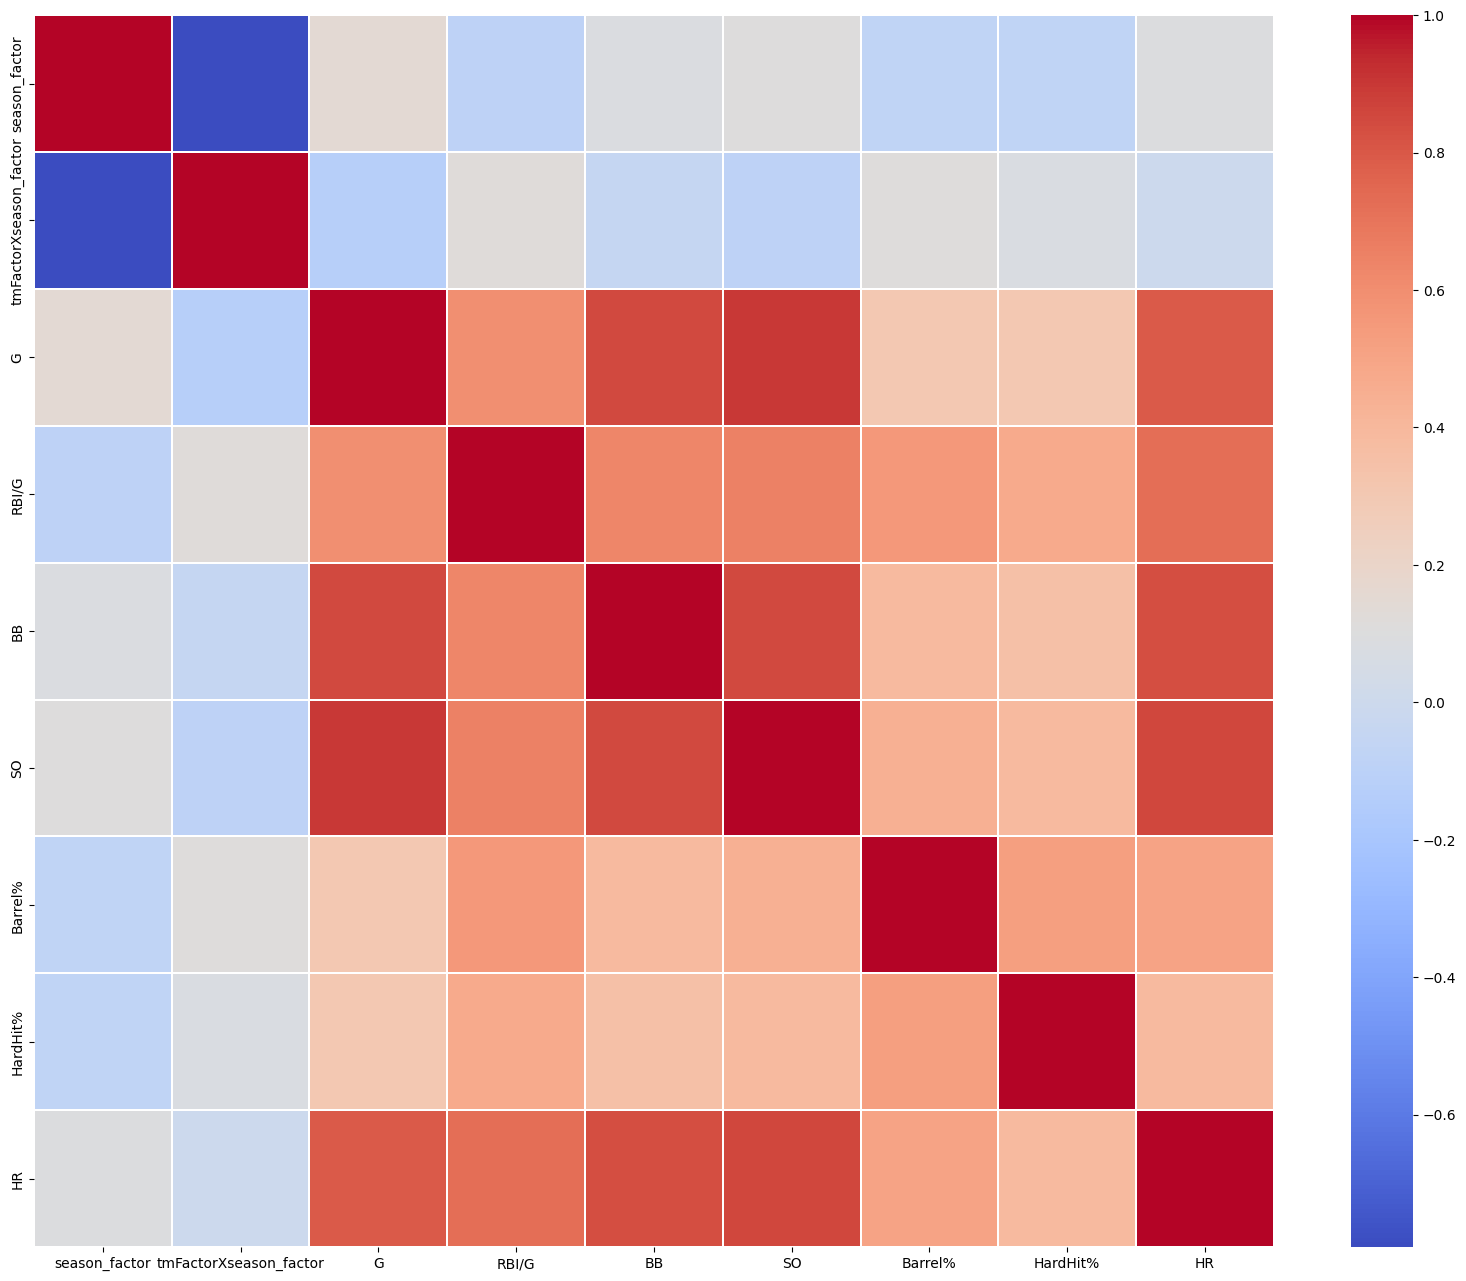

In [29]:
selected_columns = ['season_factor', 'tmFactor', 'G', 'RBI', 'BB', 'SO', 'Barrel%', 'HardHit%', 'HR']
temp_players_df =  players_df[selected_columns].dropna(ignore_index=True)

temp_players_df['tmFactor'] = temp_players_df['tmFactor']/temp_players_df['season_factor']
temp_players_df.rename(columns={'tmFactor': 'tmFactorXseason_factor'}, inplace=True)

temp_players_df['RBI'] = temp_players_df['RBI']/temp_players_df['G']
temp_players_df.rename(columns={'RBI': 'RBI/G'}, inplace=True)

correlation_matrix = temp_players_df.corr()
plt.figure(figsize=(20,16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.1)
plt.show()

In [30]:
target = "HR"
target_corr = correlation_matrix[target].sort_values(ascending=False)

print("Feature Correlation with Target:")
print(target_corr.to_string())

Feature Correlation with Target:
HR                        1.000000
SO                        0.853256
BB                        0.837103
G                         0.796386
RBI/G                     0.725833
Barrel%                   0.502960
HardHit%                  0.389474
season_factor             0.092800
tmFactorXseason_factor   -0.005657


In [31]:
final_features = temp_players_df.drop(columns=['season_factor', 'tmFactorXseason_factor', 'HR'])
final_features_list = final_features.columns

vif_data = pd.DataFrame()
vif_data["Feature"] = final_features_list
vif_data["VIF"] = [variance_inflation_factor(final_features.values, i) for i in range(final_features.shape[1])]

print("Variance Inflation Factor (VIF):")
print(vif_data)


Variance Inflation Factor (VIF):
    Feature        VIF
0         G  14.019825
1     RBI/G   5.708492
2        BB   7.056541
3        SO  13.938472
4   Barrel%   3.249725
5  HardHit%   4.239572


In [41]:
# Extract the column names from the dataframe
column_names = final_features.columns.tolist()
print(column_names)
column_names.extend(['HR', 'Season'])

with open('../../data/lr_model_manual_feature_list.txt', 'w') as f:
    for column in column_names:
        f.write(column + '\n')

['G', 'RBI/G', 'BB', 'SO', 'Barrel%', 'HardHit%']


In [50]:
final_features = temp_players_df.drop(columns=['G', 'HR'])
final_features_list = final_features.columns

vif_data = pd.DataFrame()
vif_data["Feature"] = final_features_list
vif_data["VIF"] = [variance_inflation_factor(final_features.values, i) for i in range(final_features.shape[1])]

print("Variance Inflation Factor (VIF):")
print(vif_data)

Variance Inflation Factor (VIF):
                  Feature       VIF
0           season_factor  5.941333
1  tmFactorXseason_factor  5.414574
2                   RBI/G  6.004343
3                      BB  6.467420
4                      SO  8.627340
5                 Barrel%  3.044863
6                HardHit%  6.153477


In [51]:
# Extract the column names from the dataframe
column_names = final_features.columns.tolist()
print(column_names)
column_names.extend(['HR', 'Season'])

with open('../../data/lr_model_manual_feature2_list.txt', 'w') as f:
    for column in column_names:
        f.write(column + '\n')

['season_factor', 'tmFactorXseason_factor', 'RBI/G', 'BB', 'SO', 'Barrel%', 'HardHit%']


In [53]:
final_features = temp_players_df.drop(columns=['SO', 'G', 'HR'])
final_features_list = final_features.columns

vif_data = pd.DataFrame()
vif_data["Feature"] = final_features_list
vif_data["VIF"] = [variance_inflation_factor(final_features.values, i) for i in range(final_features.shape[1])]

print("Variance Inflation Factor (VIF):")
print(vif_data)

Variance Inflation Factor (VIF):
                  Feature       VIF
0           season_factor  5.697066
1  tmFactorXseason_factor  5.339379
2                   RBI/G  5.707545
3                      BB  2.976279
4                 Barrel%  3.002696
5                HardHit%  6.135458


In [54]:
# Extract the column names from the dataframe
column_names = final_features.columns.tolist()
print(column_names)
column_names.extend(['HR', 'Season'])

with open('../../data/lr_model_manual_feature3_list.txt', 'w') as f:
    for column in column_names:
        f.write(column + '\n')

['season_factor', 'tmFactorXseason_factor', 'RBI/G', 'BB', 'Barrel%', 'HardHit%']
